# (Try to) identify signals of gentrification from Airbnb data

In [18]:
import os
import pandas as pd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
import sys
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

sys.path.insert(0, '../')
from PlottingFunctions import *

def dominant_and_percentage_and_count(x):
    mode_vals = pd.Series.mode(x)
    if mode_vals.empty:
        mode_val = None
        pct = 0.0
    else:
        mode_val = mode_vals.iloc[0]
        pct = (x == mode_val).mean() * 100
    count = pd.Series.count(x)
    return pd.Series({'dominant_class': mode_val, 'dominant_pct': pct, 'count': count})

city='melbourne'

### Get just Melbourne suburbs

In [19]:
central_suburbs = gpd.read_file(f"../../../data/SpatialData/MelbourneSuburbs.shp")
central_suburbs[['SAL_NAME21', "geometry"]].head()

,SAL_NAME21,geometry
0,Abbotsford (Vic.),"POLYGON ((145.00195 -37.79665, 145.0019 -37.79..."
1,Aberfeldie,"POLYGON ((144.89576 -37.76514, 144.89547 -37.7..."
2,Airport West,"POLYGON ((144.87979 -37.71565, 144.88016 -37.7..."
3,Albert Park (Vic.),"POLYGON ((144.95445 -37.83794, 144.95691 -37.8..."
4,Albion (Vic.),"POLYGON ((144.82393 -37.77649, 144.82402 -37.7..."


## Get gentrification scores for each listing

In [20]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
# score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_one_per_lsoa_10.csv')
score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_03.csv')

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction'].map(mapping)
# Remove rows with an error
score_per_listing = score_per_listing[score_per_listing['explanation'] != 'ERROR']
score_per_listing = score_per_listing[['gentrification_prediction', 'explanation', 'gentrification_prediction_code', 'longitude',
                                              'latitude']]
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction_code'].astype(int)
score_per_listing.head()

,gentrification_prediction,explanation,gentrification_prediction_code,longitude,latitude
0,Gentrifying,"The area is described as green, safe, and quie...",3,144.99975,-37.79906
1,Established,"The listing highlights the area's trendy, mode...",4,145.01346,-37.81176
2,Gentrifying,"The description mentions the area's quiet, saf...",3,144.99755,-37.79846
3,Gentrifying,The listing emphasizes the area's eclectic cha...,3,145.00404,-37.80942
4,Established,The description highlights the area's inner-ci...,4,144.99663,-37.80311


### Convert to geodataframe of scores per listing

In [21]:
score_per_listing['geometry'] = score_per_listing.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
score_per_listing_gdf = gpd.GeoDataFrame(score_per_listing, geometry='geometry', crs="EPSG:4326")
score_per_listing_gdf.head()

,gentrification_prediction,explanation,gentrification_prediction_code,longitude,latitude,geometry
0,Gentrifying,"The area is described as green, safe, and quie...",3,144.99975,-37.79906,POINT (144.99975 -37.79906)
1,Established,"The listing highlights the area's trendy, mode...",4,145.01346,-37.81176,POINT (145.01346 -37.81176)
2,Gentrifying,"The description mentions the area's quiet, saf...",3,144.99755,-37.79846,POINT (144.99755 -37.79846)
3,Gentrifying,The listing emphasizes the area's eclectic cha...,3,145.00404,-37.80942,POINT (145.00404 -37.80942)
4,Established,The description highlights the area's inner-ci...,4,144.99663,-37.80311,POINT (144.99663 -37.80311)


### Find which Suburb each listing is within

In [22]:
score_per_listing_with_suburb = gpd.sjoin(
    score_per_listing_gdf,
    central_suburbs[['SAL_NAME21', 'geometry']],
    how='right',
    predicate='within')

del score_per_listing_with_suburb['geometry']
del score_per_listing_with_suburb['index_left']
score_per_listing_with_suburb.reset_index(inplace=True, drop=True)
score_per_listing_with_suburb.head()

,gentrification_prediction,explanation,gentrification_prediction_code,longitude,latitude,SAL_NAME21
0,Gentrifying,"The area is described as green, safe, and quie...",3.0,144.99975,-37.79906,Abbotsford (Vic.)
1,Established,"The listing highlights the area's trendy, mode...",4.0,145.01346,-37.81176,Abbotsford (Vic.)
2,Gentrifying,"The description mentions the area's quiet, saf...",3.0,144.99755,-37.79846,Abbotsford (Vic.)
3,Gentrifying,The listing emphasizes the area's eclectic cha...,3.0,145.00404,-37.80942,Abbotsford (Vic.)
4,Established,The description highlights the area's inner-ci...,4.0,144.99663,-37.80311,Abbotsford (Vic.)


## Create a dataframe with a count of the number of listings in each LSOA, and the modal score

In [23]:
per_suburb_summary = (score_per_listing_with_suburb
    .groupby("SAL_NAME21")["gentrification_prediction_code"]
    .apply(dominant_and_percentage_and_count)
    .unstack()
    .reset_index())

per_suburb_summary = central_suburbs[['SAL_NAME21', 'geometry']].merge(per_suburb_summary, on='SAL_NAME21')
per_suburb_summary = per_suburb_summary[per_suburb_summary['dominant_class'].notnull()]
per_suburb_summary['dominant_class'] = per_suburb_summary['dominant_class'].astype(int)
per_suburb_summary.head()

,SAL_NAME21,geometry,dominant_class,dominant_pct,count
0,Abbotsford (Vic.),"POLYGON ((145.00195 -37.79665, 145.0019 -37.79...",3,66.336634,202.0
1,Aberfeldie,"POLYGON ((144.89576 -37.76514, 144.89547 -37.7...",4,100.000000,3.0
2,Airport West,"POLYGON ((144.87979 -37.71565, 144.88016 -37.7...",4,47.619048,21.0
3,Albert Park (Vic.),"POLYGON ((144.95445 -37.83794, 144.95691 -37.8...",4,96.116505,103.0
4,Albion (Vic.),"POLYGON ((144.82393 -37.77649, 144.82402 -37.7...",2,53.846154,13.0


In [24]:
cmap = plt.get_cmap('viridis', 5)
plot_colors = [cmap(i) for i in range(5)]
color_map = dict(zip(range(5), plot_colors))
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)

In [25]:
per_suburb_summary['color'] = per_suburb_summary['dominant_class'].map(cmap)
# plot_colors = [cmap(i) for i in range(5)]
# color_map = dict(zip(range(5), plot_colors))
# score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)

# fig,ax=plt.subplots(figsize=(10,10))

# # Plot using the 'color' column directly
# per_suburb_summary_wm = per_suburb_summary.to_crs(epsg=3857)
# per_suburb_summary_wm.plot(color=per_suburb_summary_wm['color'], alpha=1, ax=ax, edgecolor='black')

# score_per_listing_gdf_wm = score_per_listing_gdf.to_crs(epsg=3857)
# score_per_listing_gdf_wm.plot(color=score_per_listing_gdf_wm['color'], ax=ax, legend=True, alpha=1, edgecolor='black', markersize=50);

# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=score_per_listing_gdf_wm.crs)

# ax.axis("off");

# Gentrification index comparison

In [26]:
g_index = pd.read_csv(f"../../../data/GentrificationIndex/MelbourneIndex/FromGuardian.csv")
g_index = g_index.merge(central_suburbs, on='SAL_NAME21', how='left')
g_index = g_index[g_index['geometry'].notnull()]
g_index_gdf = gpd.GeoDataFrame(g_index, geometry='geometry', crs="EPSG:4326")

# Add colour column to plot from
cmap = plt.get_cmap('viridis', 9)
colors = [cmap(i) for i in range(9)]
color_map = dict(zip(range(9), colors))
g_index_gdf['color']= g_index_gdf['Classification'].map(color_map)

## Plot

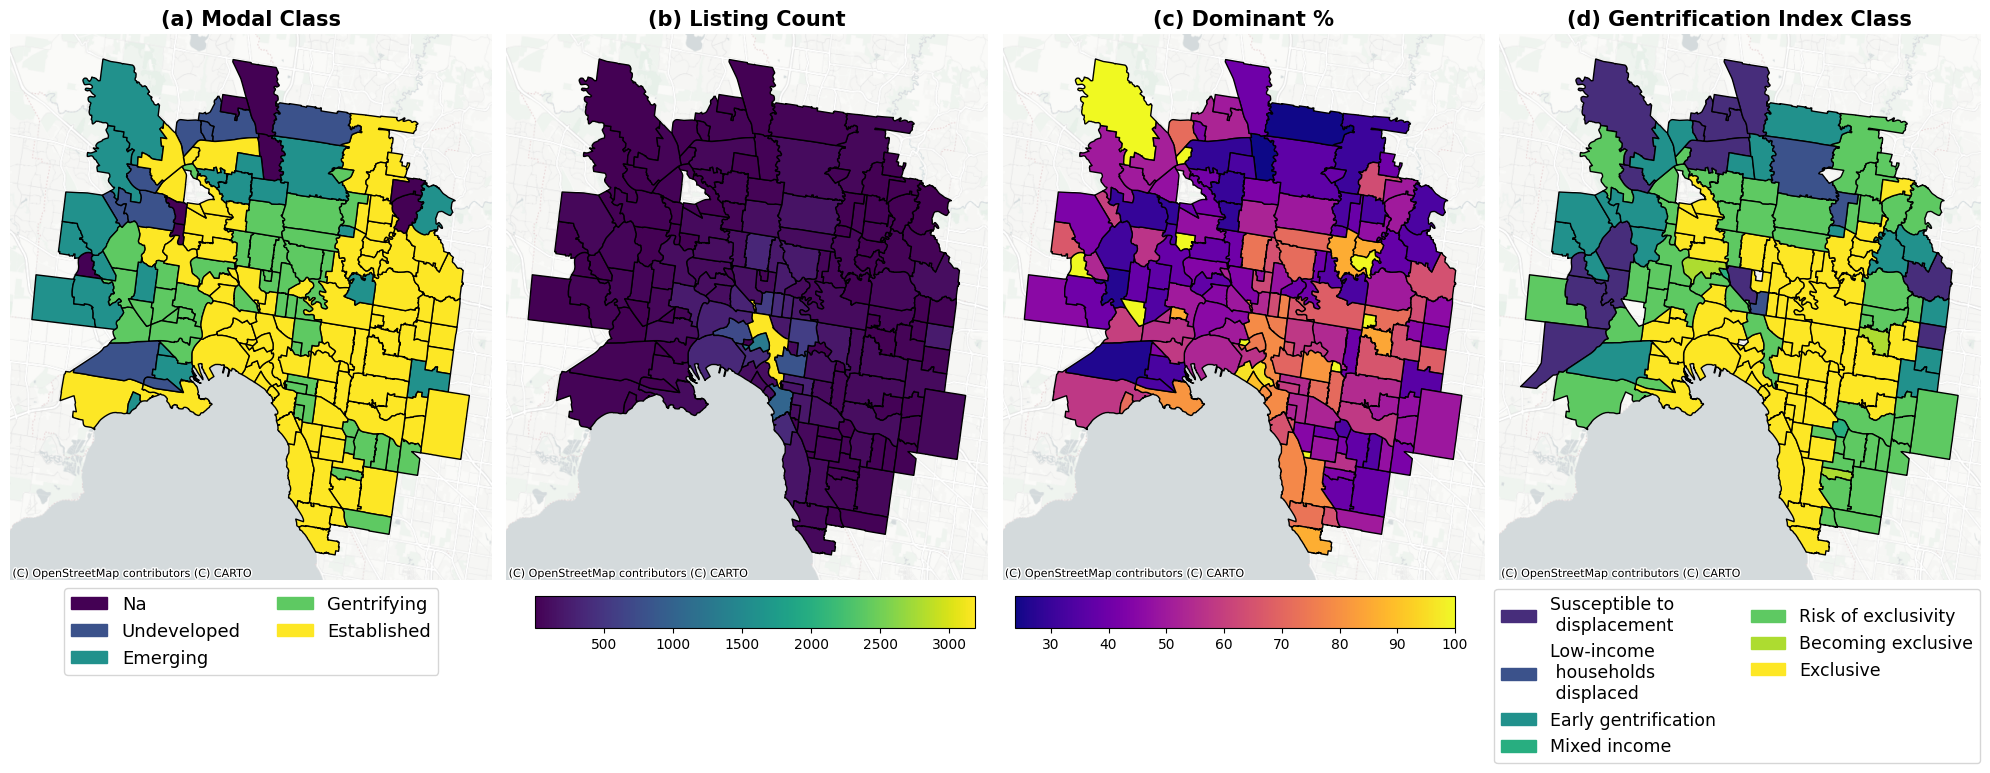

In [27]:
# Common legend keyword settings
legend_opts = {"orientation": "horizontal", "pad": 0.02, "aspect": 30}

# Ensure CRS is web mercator for basemap
per_suburb_summary = per_suburb_summary.to_crs(epsg=3857)
g_index_gdf = g_index_gdf.to_crs(epsg=3857)

# --- Create figure and axes (NO constrained_layout!)
fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

# (a) Modal class map
per_suburb_summary.plot(
    color=per_suburb_summary["color"], ax=axs[0], edgecolor='black', legend=False)
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[0].set_title("(a) Modal Class", fontweight='bold', fontsize=15)

# (b) Listing count
count_col = "count"
count_cmap = "viridis"
count_vmin, count_vmax = per_suburb_summary[count_col].min(), per_suburb_summary[count_col].max()
per_suburb_summary.plot(count_col, cmap=count_cmap, vmin=count_vmin, vmax=count_vmax,
                        alpha=1, ax=axs[1], legend=False, edgecolor='black')
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[1].set_title("(b) Listing Count", fontweight='bold', fontsize=15)

# (c) Dominant %
dom_col = "dominant_pct"
dom_cmap = "plasma"
dom_vmin, dom_vmax = per_suburb_summary[dom_col].min(), per_suburb_summary[dom_col].max()
per_suburb_summary.plot(dom_col, cmap=dom_cmap, vmin=dom_vmin, vmax=dom_vmax,
                        alpha=1, ax=axs[2], legend=False, edgecolor='black')
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[2].set_title("(c) Dominant %", fontweight='bold', fontsize=15)

# (d) Gentrification Index
g_index_gdf.plot(color=g_index_gdf["color"], ax=axs[3], legend=False, edgecolor='black')
ctx.add_basemap(axs[3], source=ctx.providers.CartoDB.Positron, crs=g_index_gdf.crs)
axs[3].set_title("(d) Gentrification Index Class", fontweight='bold', fontsize=15)

# --- Turn off axes
for ax in axs:
    ax.axis('off')
    ax.set_aspect('auto')

# --- Adjust bottom space for legends and colorbars
plt.tight_layout()
fig.subplots_adjust(bottom=0.25)  # extra bottom margin

# --- Discrete legends
mapping = {'Na': 0, 'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
modal_patches = [
    mpatches.Patch(
        color=per_suburb_summary.loc[per_suburb_summary["dominant_class"] == k, "color"].iloc[0],
        label=label
    )
    for k, label in class_labels.items()
]

mapping_idx = {
    1: 'Susceptible to \n displacement', 2: "Low-income \n households \n displaced",
    4: "Early gentrification", 5: "Mixed income", 6: "Risk of exclusivity",
    7: "Becoming exclusive", 8: "Exclusive"
}
gi_patches = [
    mpatches.Patch(
        color=g_index_gdf.loc[g_index_gdf["Classification"] == k, "color"].iloc[0],
        label=label
    )
    for k, label in mapping_idx.items()
]

# --- Colorbars along bottom
cbar_ax1 = fig.add_axes([0.27, 0.19, 0.22, 0.04])  # for count [left, bottom, width, height]
cbar_ax2 = fig.add_axes([0.51, 0.19, 0.22, 0.04])  # for dominant %

count_norm = mpl.colors.Normalize(vmin=count_vmin, vmax=count_vmax)
count_sm = mpl.cm.ScalarMappable(norm=count_norm, cmap=count_cmap)
cbar1 = fig.colorbar(count_sm, cax=cbar_ax1, orientation='horizontal')
# cbar1.set_label("Listing Count", fontsize=12)

dom_norm = mpl.colors.Normalize(vmin=dom_vmin, vmax=dom_vmax)
dom_sm = mpl.cm.ScalarMappable(norm=dom_norm, cmap=dom_cmap)
cbar2 = fig.colorbar(dom_sm, cax=cbar_ax2, orientation='horizontal')
# cbar2.set_label("Dominant %", fontsize=12)

# --- Legends below
fig.legend(
    handles=modal_patches,
    loc='lower left', bbox_to_anchor=(0.03, 0.12), #[height]
    frameon=True, ncol=2, prop={'size': 13},
#     title="Modal Class"
)

fig.legend(
    handles=gi_patches,
    loc='lower right', bbox_to_anchor=(0.997, 0.01),
    frameon=True, ncol=2, prop={'size': 12.5},
#     title="Gentrification Index Class"
)

# --- Save and show
fig.savefig("../Figures/Melbourne_LLM-scores.png", bbox_inches='tight', dpi=300)
plt.show()


In [28]:
# np.unique(g_index['Classification'], return_counts=True)

# (len(g_index['Classification'])-7)/len(g_index['Classification']) * 100

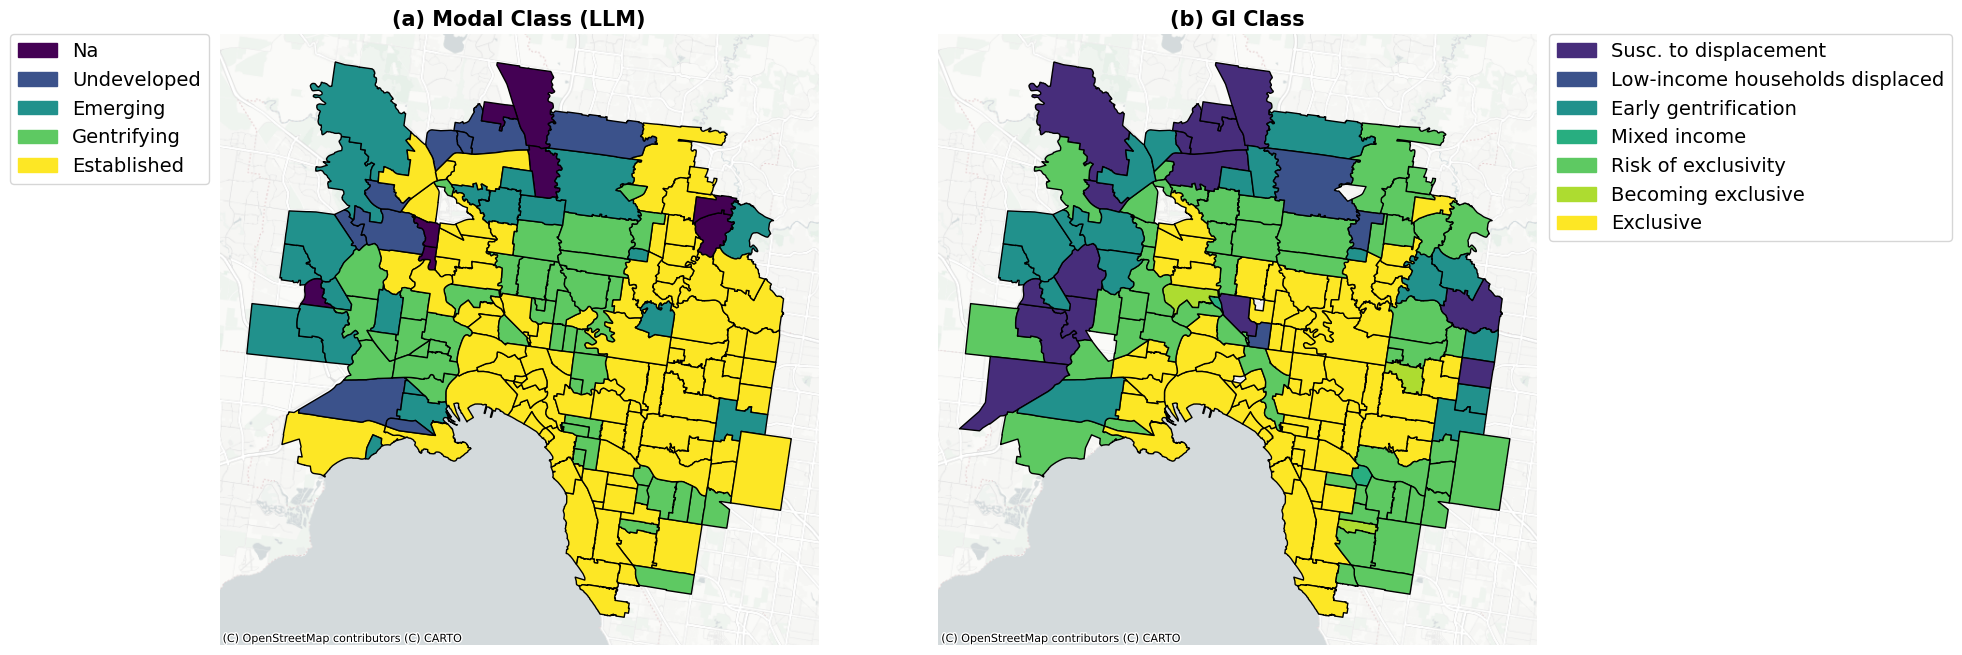

In [29]:
fig, axs = plt.subplots(ncols = 2, figsize=(17, 10), sharey=True, sharex=True)

g_index_gdf = g_index_gdf.to_crs(epsg=3857)

############# Plot LLM data
per_suburb_summary.plot(color=per_suburb_summary["color"], ax=axs[0], legend=False, edgecolor='black')
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15);

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches = [mpatches.Patch(color=per_suburb_summary.loc[per_suburb_summary["dominant_class"] == k, "color"].iloc[0], label=label) 
           for k, label in class_labels.items()]

# axs[0].legend(handles=patches, loc="lower left", frameon=True, prop={'size': 10})
axs[0].legend(handles=patches,loc="upper left", bbox_to_anchor=(-0.35, 1), borderaxespad=0., frameon=True,prop={'size': 14})

#####################
# ############# Plot GI data
g_index_gdf.plot(color=g_index_gdf["color"], ax=axs[1], legend=False, edgecolor='black')
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=g_index_gdf.crs)
axs[1].set_title("(b) Gent. Idx Score", fontweight='bold', fontsize=15);

mapping_idx = {1: 'Susc. to displacement', 2: "Low-income households displaced",
           4: "Early gentrification", 5: "Mixed income", 6:"Risk of exclusivity", 7: "Becoming exclusive",
           8 : "Exclusive"}
patches = [mpatches.Patch(color=g_index_gdf.loc[g_index_gdf["Classification"] == k, "color"].iloc[1], label=label) 
           for k, label in mapping_idx.items()]

axs[1].legend(handles=patches,loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0., frameon=True,prop={'size': 14})
# axs[1].legend(handles=patches, bbox_to_anchor=(0.59, -0.1), borderaxespad=0., ncol = 2, frameon=True,prop={'size': 10})

axs[1].set_title("(b) GI Class", fontweight='bold', fontsize=15);

for ax in axs:
    ax.axis("off");

fig.savefig("../Figures/Melbourne_LLLM-Score_vs_GI-Score.png", bbox_inches = 'tight')    

# Cross tabulation comparison
### Prepare data

In [30]:
score_per_suburb_with_index = per_suburb_summary[['SAL_NAME21', 'dominant_class', 'geometry']].merge(g_index[['SAL_NAME21', 'Classification']], on='SAL_NAME21', how='left')

In [31]:
score_per_listing_with_index = score_per_listing_with_suburb.merge(g_index_gdf[['SAL_NAME21', 'Classification','geometry']],
    on='SAL_NAME21',how='left' )
score_per_listing_with_index = score_per_listing_with_index[['Classification', 'gentrification_prediction_code', 'gentrification_prediction', 'geometry']]
score_per_listing_with_index_gdf = gpd.GeoDataFrame(score_per_listing_with_index, geometry='geometry', crs="EPSG:4326")

In [32]:
# Remove empty/almost empty categories
score_per_suburb_with_index_filtered = score_per_suburb_with_index[~score_per_suburb_with_index['Classification'].isin([5, 2, 7])]
score_per_suburb_with_index_filtered= score_per_suburb_with_index_filtered[~score_per_suburb_with_index_filtered['Classification'].isin([5, 2, 7])]

In [33]:
# np.unique(score_per_suburb_with_index['Classification'], return_counts=True)
# 3/len(score_per_suburb_with_index['Classification']) *100

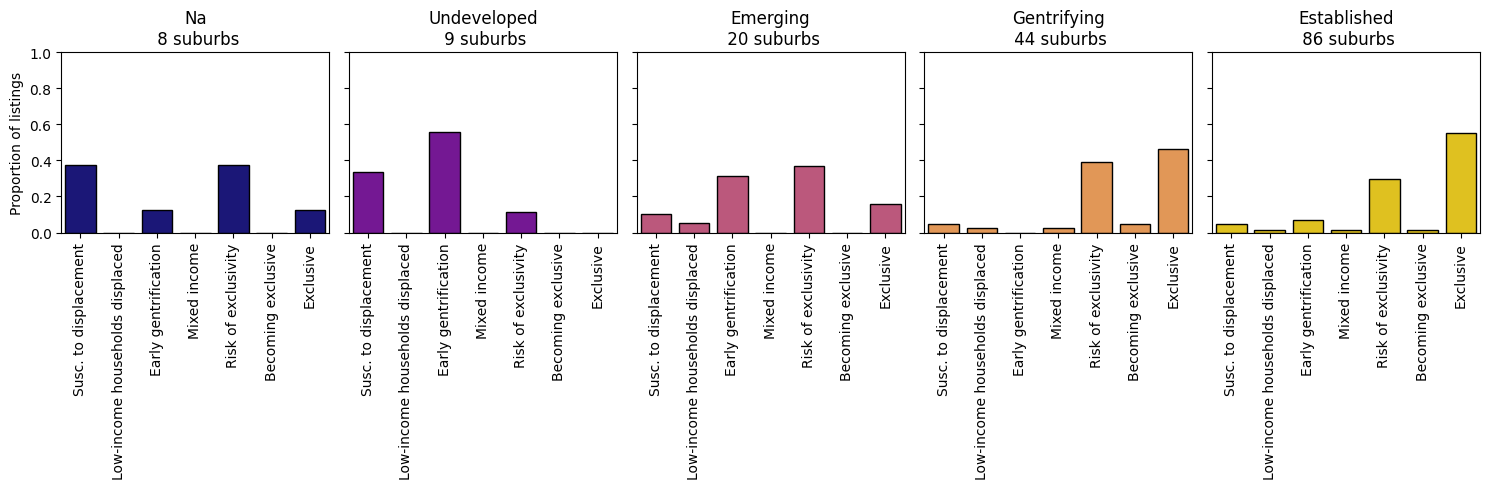

In [34]:
mapping_idx = {1: 'Susc. to displacement', 2: "Low-income households displaced",
               4: "Early gentrification", 5: "Mixed income", 6:"Risk of exclusivity", 
               7: "Becoming exclusive", 8 : "Exclusive"}

mapping = {0: 'Na', 1: 'Undeveloped', 2: 'Emerging', 3:'Gentrifying', 4:'Established'}

# order of categories in the desired plotting sequence
order = list(mapping_idx.values())

cmap = plt.get_cmap('plasma', 5)
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

fig, axs = plt.subplots(ncols=5, figsize=(15,5), sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class0 = score_per_suburb_with_index[
        score_per_suburb_with_index['dominant_class'] == gentr_class
    ].copy()

    class0['Classification_name'] = class0['Classification'].map(mapping_idx)
    class0['dominant_class_name'] = class0['dominant_class'].map(mapping)
    
    if class0.empty:
        # ax.set_axis_off()
        pass
    else:
        # compute proportions
        proportions = (
            class0['Classification_name']
            .value_counts(normalize=True)  # normalize=True → gives proportions
            .reindex(order, fill_value=0)  # ensure consistent category order
        )

        sns.barplot(
            x=proportions.index,
            y=proportions.values,
            ax=ax,
            color=plot_colors[gentr_class],
            edgecolor='black'
        )

        ax.set_ylim(0, 1)  # proportion scale
        ax.set_ylabel('Proportion of listings' if gentr_class == 0 else '')  # only first subplot
        ax.set_xlabel('')
        ax.set_title(f"{class0['dominant_class_name'].unique()[0]}\n {len(class0)} suburbs")
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()
fig.savefig("../Figures/Melbourne_CountPerGroup.png", bbox_inches = 'tight')

### Prepare crosstab

In [46]:
crosstab = pd.crosstab(score_per_suburb_with_index_filtered['dominant_class'], score_per_suburb_with_index_filtered['Classification'])
# Create row-wise percentage options
crosstab_row_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
# Col-wise
crosstab_col_pct = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Add labels
inv_mapping = {v: k for k, v in mapping.items()}
inv_mapping_idx = {v: k for k, v in mapping_idx.items()}

crosstab.rename(index=inv_mapping, columns=mapping_idx, inplace=True)
crosstab_row_pct.rename(index=inv_mapping, columns=inv_mapping_idx, inplace=True)

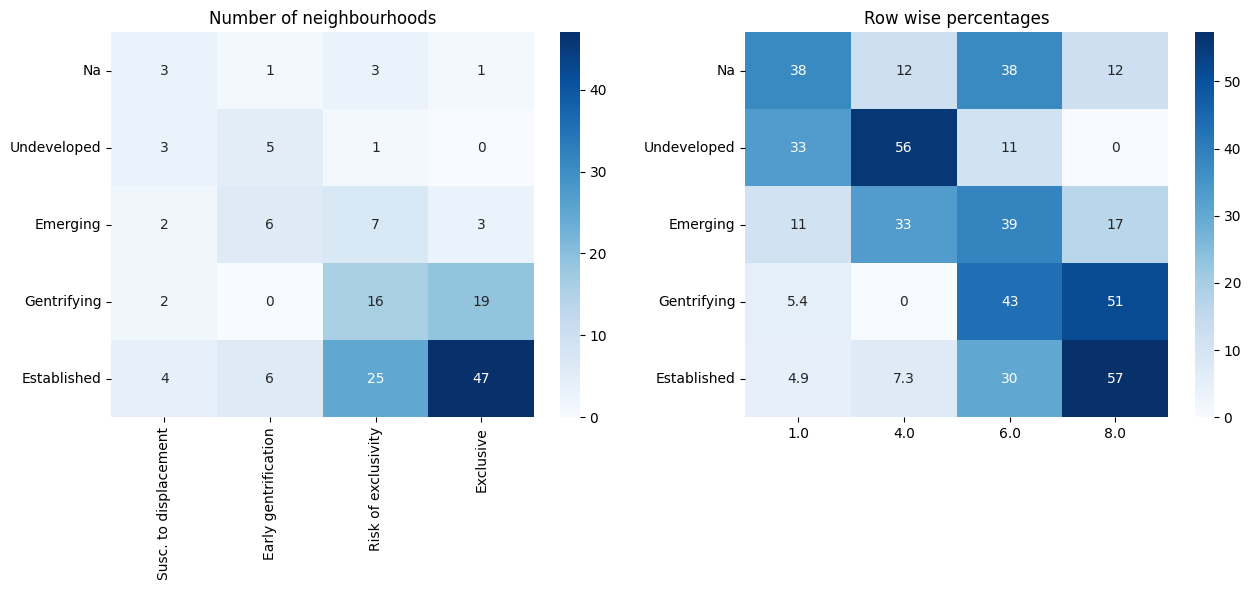

In [47]:
fig,axs=plt.subplots(ncols=2, figsize=(15,5))
sns.heatmap(crosstab, ax=axs[0], annot=True, cmap='Blues', fmt=".0f")
axs[0].set_title("Number of neighbourhoods")
axs[0].set_xlabel("")
axs[0].set_ylabel("")
# sns.heatmap(crosstab_col_pct, ax=axs[1], annot=True, cmap='Blues', fmt=".0f")
# axs[1].set_title("Col wise percentages")
# axs[1].set_xlabel("")
# axs[1].set_ylabel("")
sns.heatmap(crosstab_row_pct, ax=axs[1], annot=True, cmap='Blues')
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_title("Row wise percentages");

fig.savefig("../Figures/Melbourne_crosstabs.png", bbox_inches = 'tight')   

### Difference plot

In [38]:
new_mapping = {1: 0, 2: 1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4}
score_per_suburb_with_index['Classification_new'] = score_per_suburb_with_index['Classification'].map(new_mapping)
score_per_suburb_with_index['Diff'] = score_per_suburb_with_index['dominant_class'] - score_per_suburb_with_index['Classification_new']

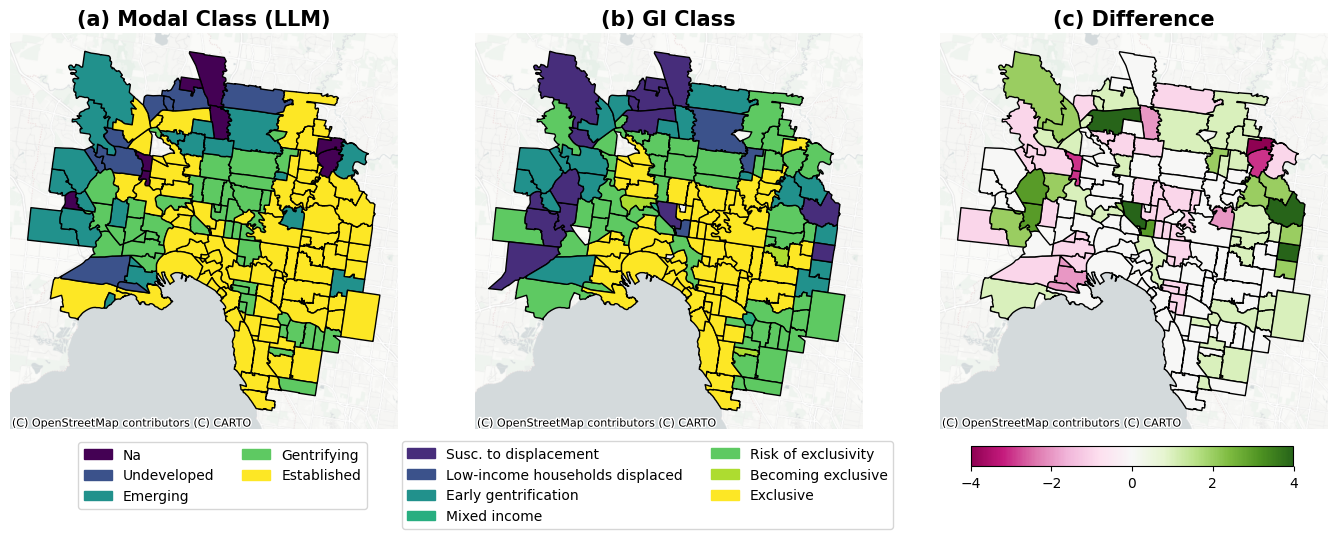

In [39]:
fig, axs = plt.subplots(ncols=3, figsize=(17, 10), sharey=True, sharex=True)
g_index_gdf = g_index_gdf.to_crs(epsg=3857)

# (a) LLM map
per_suburb_summary.plot(color=per_suburb_summary["color"], ax=axs[0], legend=False, edgecolor='black')
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15)
axs[0].axis("off")

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches_llm = [mpatches.Patch(color=per_suburb_summary.loc[per_suburb_summary["dominant_class"] == k, "color"].iloc[0], 
                              label=label) for k, label in class_labels.items()]

# (b) GI map
g_index_gdf.plot(color=g_index_gdf["color"], ax=axs[1], legend=False, edgecolor='black')
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=g_index_gdf.crs)
axs[1].set_title("(b) GI Class", fontweight='bold', fontsize=15)
axs[1].axis("off")

mapping_idx = {1: 'Susc. to displacement', 2: "Low-income households displaced",
               4: "Early gentrification", 5: "Mixed income", 6:"Risk of exclusivity", 
               7: "Becoming exclusive", 8 : "Exclusive"}
patches_gi = [mpatches.Patch(color=g_index_gdf.loc[g_index_gdf["Classification"] == k, "color"].iloc[1], 
                             label=label) for k, label in mapping_idx.items()]

# (c) Diff map with colorbar
diff_plot = score_per_suburb_with_index.plot('Diff', ax=axs[2], cmap='PiYG', legend=False, edgecolor='black')
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[2].set_title("(c) Difference", fontweight='bold', fontsize=15)
axs[2].axis("off")

# --- Create legends & colorbar at the bottom ---
# 1. LLM legend
leg1 = fig.legend(handles=patches_llm, loc='lower center', bbox_to_anchor=(0.25, 0.21),
                  frameon=True, ncol=len(patches_llm)//2, prop={'size': 10})

# 2. GI legend
leg2 = fig.legend(handles=patches_gi, loc='lower center', bbox_to_anchor=(0.5, 0.19),
                  frameon=True, ncol=2, prop={'size': 10})

# 3. Diff colorbar (same height as legends)
cbar_ax = fig.add_axes([0.69, 0.26, 0.19, 0.02])  # [left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=score_per_suburb_with_index['Diff'].min(), 
                             vmax=score_per_suburb_with_index['Diff'].max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='PiYG'),
                    cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)

# plt.tight_layout(rect=[0, 0.1, 1, 1])  # leave space at bottom for legends/cbar
fig.savefig("../Figures/Melbourne_LLLM-Score_vs_GI-Score.png", bbox_inches='tight', dpi=300)